In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


from scipy.signal import welch, correlate, find_peaks
from scipy import stats
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar



In [2]:
#%aimport functions
from functions import *
#%autoreload 1

In [3]:
class PulsarDataFile:
    def __init__(self, file_path, data_type="ascii", channel_1_name="ch1", channel_2_name="ch2", block_size=512, avg_blocks=60, sample_rate=33e6):
        self.file_path = file_path
        self.data_type = data_type
        self.channel_1_name = channel_1_name
        self.channel_2_name = channel_2_name
        self.block_size = block_size
        self.avg_blocks = avg_blocks
        self.sample_rate = sample_rate  # in Hz

        self.raw_data = None
        self.intensity_matrix_ch1 = None
        self.intensity_matrix_ch2 = None

    def load_data(self):
        if self.data_type == 'ascii':
            self.raw_data = np.loadtxt(self.file_path)
        elif self.data_type == 'binary':
            self.raw_data = np.fromfile(self.file_path, dtype=np.int32).reshape(-1, 4)
            #self.raw_data = temp_data[~np.isnan(temp_data).any(axis=1)]
        else:
            raise ValueError("Unsupported data type. Use 'ascii' or 'binary'.")

        if self.raw_data.ndim != 2 or self.raw_data.shape[1] != 2:
            raise ValueError("Expected 2-column data. Given Data is of ndim : {self.raw_data.ndim} . shape : {self.raw_data.shape[1]}")

    def compute_intensity_matrix(self):

        if self.raw_data is None:
            raise ValueError("Data not loaded. Please call load_data() first.")
        
        def compute_channel_matrix(channel_data):
            total_samples = len(channel_data)
            segment_length = self.block_size * self.avg_blocks
            num_segments = total_samples // segment_length
            trimmed = channel_data[:num_segments * segment_length]
            reshaped = trimmed.reshape(num_segments * self.avg_blocks, self.block_size)
            fft_data = np.fft.rfft(reshaped, axis=1)  # Use rfft for real inputs
            power_spectra = np.abs(fft_data) ** 2
            power_avg = power_spectra.reshape(num_segments, self.avg_blocks, -1).mean(axis=1)
            return power_avg

        ch1 = self.raw_data[:, 0]
        ch2 = self.raw_data[:, 1]

        self.intensity_matrix_ch1 = compute_channel_matrix(ch1)
        self.intensity_matrix_ch2 = compute_channel_matrix(ch2)



In [4]:

class Visualizer:
    def __init__(self, pulsar_data: PulsarDataFile):
        self.data = pulsar_data

    def random_sample_hist(self, max_samples=100000):
        data = self.data.raw_data
        if data is None:
            raise ValueError("No data loaded.")

        labels = [self.data.channel_1_name, self.data.channel_2_name]
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

        for i, ax in enumerate(axes):
            idx = np.random.choice(data.shape[0], size=min(max_samples, data.shape[0]), replace=False)
            sample = data[idx, i]
            mean, std = np.mean(sample), np.std(sample)
            print(f"{labels[i]} mean = {mean:.3f}, std = {std:.3f}")
            ax.hist(sample, bins=200, alpha=0.7, label=labels[i], color=('green' if i == 0 else 'orange'))
            ax.set_title(f"{labels[i]} Histogram")
            ax.set_xlabel("Amplitude")
            ax.legend()

        axes[0].set_ylabel("Count")
        plt.suptitle("Random Sample Histogram (Separate Channels)")
        plt.tight_layout(rect=(0, 0.03, 1, 0.95))
        plt.show()

    def plot_intensity_matrix(self, channel=1, gamma=2.5, dedispersed=False):
        """
        Plot the dynamic spectrum for the specified channel.

        Parameters:
            channel (int): 1 or 2
            gamma (float): Gamma correction for power normalization
            dedispersed (bool): Whether to plot the dedispersed matrix
        """
        
        if dedispersed:
            if channel == 1:
                matrix = self.data.dedispersed_ch1
            elif channel == 2:
                matrix = self.data.dedispersed_ch2
            else:
                raise ValueError("Channel must be 1 or 2.")
            title_suffix = " (Dedispersed)"
        else:
            if channel == 1:
                matrix = self.data.intensity_matrix_ch1
            elif channel == 2:
                matrix = self.data.intensity_matrix_ch2
            else:
                raise ValueError("Channel must be 1 or 2.")
            title_suffix = ""

        if matrix is None:
            raise ValueError("Requested intensity matrix not computed.")
        num_segments = matrix.shape[0]
        time_extent = num_segments * (self.data.avg_blocks * self.data.block_size / self.data.sample_rate) * 1e6  # μs
        freq_channels = matrix.shape[1]

        # Generate frequency array for each channel
        bandwidth = 16.5  # MHz
        center_freq = 326.5  # MHz
        freq_array = np.linspace(center_freq + bandwidth / 2,center_freq - bandwidth / 2, freq_channels)

        plt.figure(figsize=(10, 6))
        plt.imshow(matrix.T, aspect='auto', origin='upper', cmap='turbo',
                norm=colors.PowerNorm(gamma=gamma),
                extent=(0, time_extent, freq_array[-1], freq_array[0]))
        plt.colorbar(label="Log Power")
        plt.xlabel("Time (μs)")
        plt.ylabel("Frequency (MHz)")
        plt.title(f"Dynamic Spectrum (Channel {channel}){title_suffix}")

        # Set yticks to a reasonable number of frequency labels
        n_ticks = 8
        yticks = np.linspace(freq_array[0], freq_array[-1], n_ticks)
        plt.yticks(yticks)
        plt.show()

    # ploting the basic characterstic of the noise / signal for channel specified by user.
    # Stitch all data arrays for each channel one after the other
    #ch1 = np.concatenate([np.array(d['ch1']) for d in df])
    # Create a figure with subplots

    def Plot_characterstics(self, channel=2):
        """
        Plot basic characteristics of the noise/signal for the specified channel.
        Parameters:
            channel (int): 1 or 2 (default 2)
        """
        # Select the channel data
        if channel == 1:
            ch = self.data.raw_data[:10000, 0]
            label = self.data.channel_1_name if hasattr(self.data, "channel_1_name") else "Channel 1"
            color = 'green'
        else:
            ch = self.data.raw_data[:10000, 1]
            label = self.data.channel_2_name if hasattr(self.data, "channel_2_name") else "Channel 2"
            color = 'darkorange'

        # Time axis
        n_samples = ch.shape[0]
        sample_rate = self.data.sample_rate if hasattr(self.data, "sample_rate") else 1.0
        time = np.arange(n_samples) / sample_rate

        # Power Spectral Density using Welch method
        f, Pxx = welch(ch, fs=sample_rate, nperseg=1024)

        fig, axs = plt.subplots(3, 1, figsize=(12, 15))

        # Plot 1: Time Series Plot
        axs[0].plot(time * 1e6, ch, label=label, color=color, alpha=0.7)
        axs[0].set_xlabel('Time (µs)')
        axs[0].set_ylabel('Voltage (V)')
        axs[0].set_title(f'Time Series of Noise Signals ({label})')
        axs[0].legend()
        axs[0].grid(True)

        # Plot 2: Power Spectral Density using Welch method
        axs[1].semilogy(f / 1e6, Pxx, label=f'{label} PSD', color=color)
        axs[1].set_xlabel('Frequency (MHz)')
        axs[1].set_ylabel('PSD (V²/Hz)')
        axs[1].set_title(f'Power Spectral Density of {label}')
        axs[1].legend()
        axs[1].grid(True, which='both')

        # Plot 3: Histogram of Voltage Values
        axs[2].hist(ch, bins=100, alpha=0.6, label=label, color=color, density=True)
        axs[2].set_xlabel('Voltage (V)')
        axs[2].set_ylabel('Probability Density')
        axs[2].set_title(f'Histogram of Voltage Values ({label})')
        axs[2].legend()
        axs[2].grid(True)

        # Adjust layout
        plt.tight_layout()
        plt.show()

    def analyze_autocorrelation(self, channel=1, label=""):
        """
        Analyze a single channel: plot time series, PSD, and autocorrelation to estimate pulsar period.
        Parameters:
            channel (int): 1 or 2 (default 1)
            label (str): Optional label for plots
        """

        # Select the channel data
        if self.data.raw_data is None:
            raise ValueError("No data loaded.")
        
        if channel == 1:
            ch_label = self.data.channel_1_name if hasattr(self.data, "channel_1_name") else "Channel 1"
        else:
            ch_label = self.data.channel_2_name if hasattr(self.data, "channel_2_name") else "Channel 2"

        # Use the intensity matrix for the selected channel
        if channel == 1:
            matrix = self.data.intensity_matrix_ch1
        else:
            matrix = self.data.intensity_matrix_ch2

        if matrix is None:
            raise ValueError("Intensity matrix not computed for this channel.")

        sample_rate = self.data.sample_rate if hasattr(self.data, "sample_rate") else 1.0
        n_time = matrix.shape[0]
        n_freq = matrix.shape[1]
        # Time axis in seconds
        time = np.arange(n_time) / sample_rate

        # Compute autocorrelation for each frequency channel
        acorrs = []
        periods = []
        for i in range(n_freq):
            ch_freq = matrix[:, i]
            n = len(ch_freq)
            acorr = correlate(ch_freq - np.mean(ch_freq), ch_freq - np.mean(ch_freq), mode='full') / n
            lags = np.arange(-n + 1, n)
            lag_times = lags / sample_rate  # lag in seconds
            mid = len(acorr) // 2
            acorr_centered = acorr[mid+1:]
            peak_idx = np.argmax(acorr_centered)
            period_estimate = lag_times[mid + 1 + peak_idx]
            acorrs.append(acorr)
            periods.append(period_estimate)

        # Average autocorrelation across all frequency channels
        avg_acorr = np.mean(acorrs, axis=0)
        avg_period = np.mean(periods)
        lags = np.arange(-n_time + 1, n_time)
        lag_times = lags / sample_rate  # lag in seconds

        # Plot for central frequency channel
        central_idx = n_freq // 2
        central_acorr = acorrs[central_idx]
        central_period = periods[central_idx]

        fig, axs = plt.subplots(3, 1, figsize=(12, 16))
        fig.suptitle(f'Channel Autocorrelation Analysis (Intensity Matrix): {label or ch_label}', fontsize=16)

        # Plot 1: Time Series for central frequency
        axs[0].plot(time, matrix[:, central_idx], color='royalblue')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_title('Time Series (Central Frequency)')
        axs[0].grid(True)

        # Plot 2: Autocorrelation for central frequency
        axs[1].plot(lag_times, central_acorr, color='purple')
        axs[1].set_xlabel('Lag (s)')
        axs[1].set_ylabel('Autocorrelation')
        axs[1].set_title('Autocorrelation (Central Frequency)')
        axs[1].axvline(central_period, color='red', linestyle='--', 
                label=f'Central Freq Period: {central_period:.6f} s')
        axs[1].legend()
        axs[1].grid(True)
        
        # Plot 3: Average autocorrelation across all frequencies
        # Find all peak positions, print them, and label the top 3 peaks on the plot

        axs[2].plot(lag_times, avg_acorr, color='darkgreen')
        axs[2].set_xlabel('Lag (s)')
        axs[2].set_ylabel('Autocorrelation')
        axs[2].set_title('Average Autocorrelation (All Frequencies)')
        axs[2].set_yscale('log')
        axs[2].axvline(avg_period, color='red', linestyle='--', 
            label=f'Avg Period: {avg_period:.6f} s')

        # Find peaks (ignore the zero lag peak)
        min_lag_idx = np.where(lag_times > 0)[0][0]
        peaks, properties = find_peaks(avg_acorr[min_lag_idx:])
        peak_lags = lag_times[min_lag_idx:][peaks]  # in seconds
        peak_heights = avg_acorr[min_lag_idx:][peaks]

        # Sort peaks by height and get top 3
        if len(peak_heights) > 0:
            top_idx = np.argsort(peak_heights)[::-1][:3]
            print("Top 3 peak positions (s):", peak_lags[top_idx])
            for i, idx in enumerate(top_idx):
                axs[2].plot(peak_lags[idx], peak_heights[idx], 'o', color='crimson')
                axs[2].annotate(f"{peak_lags[idx]:.4f} s", (peak_lags[idx], peak_heights[idx]),
                        textcoords="offset points", xytext=(0,10), ha='center', color='crimson')
        else:
            print("No peaks found in average autocorrelation.")

        axs[2].legend()
        axs[2].grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        print(f"Estimated pulsar period (average): {avg_period:.6f} s")
        print(f"Estimated pulsar period (central freq): {central_period:.6f} s")
        plt.show()





In [ ]:

class Visualizer:
    def __init__(self, pulsar_data):
        self.data = pulsar_data

    def random_sample_hist(self, max_samples=100000):
        data = self.data.raw_data
        if data is None:
            raise ValueError("No data loaded.")

        labels = [self.data.channel_1_name, self.data.channel_2_name]
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

        for i, ax in enumerate(axes):
            idx = np.random.choice(data.shape[0], size=min(max_samples, data.shape[0]), replace=False)
            sample = data[idx, i]
            mean, std = np.mean(sample), np.std(sample)
            print(f"{labels[i]} mean = {mean:.3f}, std = {std:.3f}")
            ax.hist(sample, bins=200, alpha=0.7, label=labels[i], color=('green' if i == 0 else 'orange'))
            ax.set_title(f"{labels[i]} Histogram")
            ax.set_xlabel("Amplitude")
            ax.legend()

        axes[0].set_ylabel("Count")
        plt.suptitle("Random Sample Histogram (Separate Channels)")
        plt.tight_layout(rect=(0, 0.03, 1, 0.95))
        plt.show()

    def plot_intensity_matrix(self, channel=1, gamma=2.5, dedispersed=False):
        if dedispersed:
            matrix = self.data.dedispersed_ch1 if channel == 1 else self.data.dedispersed_ch2
            title_suffix = " (Dedispersed)"
        else:
            matrix = self.data.intensity_matrix_ch1 if channel == 1 else self.data.intensity_matrix_ch2
            title_suffix = ""

        if matrix is None:
            raise ValueError("Requested intensity matrix not computed.")

        num_segments, n_freq = matrix.shape
        time_bin_us = (self.data.block_size * self.data.avg_blocks / self.data.sample_rate) * 1e6
        time_extent_ms = num_segments * time_bin_us / 1000

        # Frequency axis
        bandwidth = 16.5  # MHz
        center_freq = 326.5  # MHz
        freq_array = np.linspace(center_freq + bandwidth / 2, center_freq - bandwidth / 2, n_freq)

        plt.figure(figsize=(10, 6))
        plt.imshow(matrix.T, aspect='auto', origin='upper', cmap='turbo',
                   norm=colors.PowerNorm(gamma=gamma),
                   extent=(0, time_extent_ms, freq_array[-1], freq_array[0]))
        plt.colorbar(label="Log Power")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency (MHz)")
        plt.title(f"Dynamic Spectrum (Channel {channel}){title_suffix}")
        yticks = np.linspace(freq_array[0], freq_array[-1], 8)
        plt.yticks(yticks)
        plt.show()

    def Plot_characterstics(self, channel=2):
        ch = self.data.raw_data[:10000, channel - 1]
        label = self.data.channel_1_name if channel == 1 else self.data.channel_2_name
        color = 'green' if channel == 1 else 'darkorange'

        n_samples = ch.shape[0]
        sample_rate = self.data.sample_rate
        time = np.arange(n_samples) / sample_rate * 1e3  # ms

        f, Pxx = welch(ch, fs=sample_rate, nperseg=1024)

        fig, axs = plt.subplots(3, 1, figsize=(12, 15))

        axs[0].plot(time, ch, label=label, color=color, alpha=0.7)
        axs[0].set_xlabel('Time (ms)')
        axs[0].set_ylabel('Voltage (V)')
        axs[0].set_title(f'Time Series of Noise Signals ({label})')
        axs[0].legend()
        axs[0].grid(True)

        axs[1].semilogy(f / 1e6, Pxx, label=f'{label} PSD', color=color)
        axs[1].set_xlabel('Frequency (MHz)')
        axs[1].set_ylabel('PSD (V²/Hz)')
        axs[1].set_title(f'Power Spectral Density of {label}')
        axs[1].legend()
        axs[1].grid(True, which='both')

        axs[2].hist(ch, bins=100, alpha=0.6, label=label, color=color, density=True)
        axs[2].set_xlabel('Voltage (V)')
        axs[2].set_ylabel('Probability Density')
        axs[2].set_title(f'Histogram of Voltage Values ({label})')
        axs[2].legend()
        axs[2].grid(True)

        plt.tight_layout()
        plt.show()

    def analyze_autocorrelation(self, channel=1, label=""):
        matrix = self.data.intensity_matrix_ch1 if channel == 1 else self.data.intensity_matrix_ch2
        if matrix is None:
            raise ValueError("Intensity matrix not computed for this channel.")

        ch_label = self.data.channel_1_name if channel == 1 else self.data.channel_2_name
        sample_rate = self.data.sample_rate
        t_bin_s = (self.data.block_size * self.data.avg_blocks) / sample_rate
        n_time, n_freq = matrix.shape

        time = np.arange(n_time) * t_bin_s

        acorrs = []
        periods = []
        for i in range(n_freq):
            ch_freq = matrix[:, i]
            n = len(ch_freq)
            acorr = correlate(ch_freq - np.mean(ch_freq), ch_freq - np.mean(ch_freq), mode='full') / n
            lags = np.arange(-n + 1, n) * t_bin_s
            acorr_centered = acorr[n-1+1:]
            peak_idx = np.argmax(acorr_centered)
            period_estimate = lags[n - 1 + 1 + peak_idx]
            acorrs.append(acorr)
            periods.append(period_estimate)

        avg_acorr = np.mean(acorrs, axis=0)
        avg_period = np.mean(periods)
        lags = np.arange(-n_time + 1, n_time) * t_bin_s

        central_idx = n_freq // 2
        central_acorr = acorrs[central_idx]
        central_period = periods[central_idx]

        fig, axs = plt.subplots(3, 1, figsize=(12, 16))
        fig.suptitle(f'Channel Autocorrelation Analysis (Intensity Matrix): {label or ch_label}', fontsize=16)

        axs[0].plot(time * 1e3, matrix[:, central_idx], color='royalblue')
        axs[0].set_xlabel('Time (ms)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_title('Time Series (Central Frequency)')
        axs[0].grid(True)

        axs[1].plot(lags * 1e3, central_acorr, color='purple')
        axs[1].set_xlabel('Lag (ms)')
        axs[1].set_ylabel('Autocorrelation')
        axs[1].set_title('Autocorrelation (Central Frequency)')
        axs[1].axvline(central_period * 1e3, color='red', linestyle='--', 
                label=f'Central Freq Period: {central_period*1e3:.3f} ms')
        axs[1].legend()
        axs[1].grid(True)

        axs[2].plot(lags * 1e3, avg_acorr, color='darkgreen')
        axs[2].set_xlabel('Lag (ms)')
        axs[2].set_ylabel('Autocorrelation')
        axs[2].set_title('Average Autocorrelation (All Frequencies)')
        axs[2].set_yscale('log')
        axs[2].axvline(avg_period * 1e3, color='red', linestyle='--', 
            label=f'Avg Period: {avg_period*1e3:.3f} ms')

        min_lag_idx = np.where(lags > 0)[0][0]
        peaks, properties = find_peaks(avg_acorr[min_lag_idx:])
        peak_lags = lags[min_lag_idx:][peaks]
        peak_heights = avg_acorr[min_lag_idx:][peaks]

        if len(peak_heights) > 0:
            top_idx = np.argsort(peak_heights)[::-1][:3]
            print("Top 3 peak positions (ms):", peak_lags[top_idx] * 1e3)
            for i, idx in enumerate(top_idx):
                axs[2].plot(peak_lags[idx] * 1e3, peak_heights[idx], 'o', color='crimson')
                axs[2].annotate(f"{peak_lags[idx]*1e3:.3f} ms", (peak_lags[idx]*1e3, peak_heights[idx]),
                        textcoords="offset points", xytext=(0,10), ha='center', color='crimson')
        else:
            print("No peaks found in average autocorrelation.")

        axs[2].legend()
        axs[2].grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        print(f"Estimated pulsar period (average): {avg_period*1e3:.3f} ms")
        print(f"Estimated pulsar period (central freq): {central_period*1e3:.3f} ms")
        plt.show()


In [ ]:
import numpy as np
import os

def split_and_save_data(data, block_size=512, blocks_per_file=60, output_dir="chunks", prefix="chunk", dtype="ascii"):
    """
    Splits data into multiple smaller files.
    
    Parameters:
        data: np.ndarray
            Full dataset (1D or 2D numpy array).
        block_size: int
            Number of samples per FFT block.
        blocks_per_file: int
            Number of blocks per saved file.
        output_dir: str
            Directory where chunk files will be saved.
        prefix: str
            Prefix for output files.
        dtype: str
            'ascii' or 'binary' output format.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    chunk_size = block_size * blocks_per_file
    total_chunks = len(data) // chunk_size

    for i in range(2):
        chunk = data[i * chunk_size : (i + 1) * chunk_size]
        
        if dtype == "ascii":
            filename = os.path.join(output_dir, f"{prefix}_{i:04d}.txt")
            np.savetxt(filename, chunk, fmt="%.6f")
        elif dtype == "binary":
            filename = os.path.join(output_dir, f"{prefix}_{i:04d}.bin")
            chunk.astype(np.float32).tofile(filename)
        else:
            raise ValueError("dtype must be 'ascii' or 'binary'")
        
        print(f"Saved {filename} [{chunk.shape}]")

# Example usage:
# Assume 'data' is your loaded NumPy array (1D or 2D)
longf_data = "/home/ashwin-ubuntu/GIT/Vela_Data_analysis/Vela_Data/ch00_B0833-45_20150612_191438_011_1"

#data = np.loadtxt(longf_data)  # or fromfile if binary

#split_and_save_data(data, block_size=512, blocks_per_file=6000, output_dir="vela_chunks", dtype="ascii")


In [5]:
# Initialize and run the analysis
long_data = "./Data4Analysis/ch00_B0833-45_20150612_191438_010_4.txt"
short_data = "/home/ashwin-ubuntu/GIT/Vela_Data_analysis/Analysis/vela_chunks/chunk_0001.txt"

vela = PulsarDataFile(long_data, data_type='ascii')

vela.load_data()
vela.compute_intensity_matrix()

# Visualize
viz = Visualizer(vela)
#viz.random_sample_hist()
#viz.plot_intensity_matrix(channel=1)
#viz.plot_intensity_matrix(channel=2)


In [ ]:
# Plot dedispersed spectrum
viz.plot_intensity_matrix(channel=2, dedispersed=False)
#viz.plot_intensity_matrix_line(channel=2)
#viz.plot_intensity_matrix(channel=2, dedispersed=True)
viz.Plot_characterstics(channel=2)
viz.analyze_autocorrelation(channel=2, label="Vela Pulsar Channel 2")


In [ ]:
def dedisperse(self, DM=67.8):

    """
    Dedisperse intensity matrix using cold plasma dispersion delay.
    DM is in pc/cm^3
    """
    
    if self.intensity_matrix_ch1 is None or self.intensity_matrix_ch2 is None:
        raise ValueError("Compute intensity matrix before dedispersion.")

    for ch in [1, 2]:
        matrix = self.intensity_matrix_ch1 if ch == 1 else self.intensity_matrix_ch2
        n_time, n_freq = matrix.shape
        #print(matrix.shape)

        # # Generate frequency array for each channel
        bandwidth = 16.5 /1000 # MHz to GHz
        center_freq = 326.5 / 1000 # MHz to GHz
        freq_array = np.linspace(center_freq - bandwidth / 2, center_freq + bandwidth / 2, n_freq)

        # Reference frequency (earliest arrival): highest frequency
        f_ref = freq_array[len(freq_array)//2]
        #print(f_ref)

        # Calculate delay in microseconds for each frequency channel
        delays_ms = 4.15 * DM * (1 / freq_array**2 - 1 / f_ref**2)  # in ms
        delays_s = delays_ms  /1000 
        # print(len(delays_ms))
        # print("Delay ms",delays_ms)

        # # Time bin duration (microseconds per row)
        t_bin =  self.avg_blocks * self.block_size / self.sample_rate
        #print( "Time bin",t_bin)

        delay_bins = (delays_s / t_bin).astype(int)
        
        # # Initialize dedispersed matrix
        dedispersed = np.zeros_like(matrix)

        for i in range(n_freq):
            shift = delay_bins[i]
            dedispersed[:, i] = np.roll(matrix[:, i], shift)
            if shift > 0 :
                dedispersed[:abs(shift),i] = 0
            elif shift < 0:
                dedispersed[shift:,i] = 0
        if ch == 1:
            self.dedispersed_ch1 = dedispersed
        else:
            self.dedispersed_ch2 = dedispersed

In [ ]:
dedisperse(vela)
viz.plot_intensity_matrix(channel=2,dedispersed=False)
viz.plot_intensity_matrix(channel=2,dedispersed=True)
viz.plot_intensity_matrix(channel=1,dedispersed=True)

In [ ]:

def dedisperse(matrix, DM,block_size, avg_blocks , sample_rate , bandwidth_MHZ,center_freq_MHZ):

    """
    Dedisperse intensity matrix using cold plasma dispersion delay.
    DM is in pc/cm^3 should be DM=67.8 for vela
    """

    n_time, n_freq = matrix.shape
    #print(matrix.shape)

    # # Generate frequency array for each channel
    bandwidth = bandwidth_MHZ /1000 # MHz to GHz
    center_freq = center_freq_MHZ / 1000 # MHz to GHz

    freq_array = np.linspace(center_freq - bandwidth / 2, center_freq + bandwidth / 2, n_freq)


    # Reference frequency (earliest arrival): highest frequency
    f_ref = freq_array[len(freq_array)//2]

    # Calculate delay in microseconds for each frequency channel
    delays_ms = 4.15 * DM * (1 / freq_array**2 - 1 / f_ref**2)  # in ms
    #delays_s = delays_ms  / 1000  # to Sec


    # # Time bin duration (microseconds per row)
    t_bin =  avg_blocks * block_size / sample_rate * 1000 # in mili Sec
    #print( "Time bin",t_bin)

    delay_bins = (delays_ms / t_bin).astype(int)
    
    # # Initialize dedispersed matrix
    dedispersed = np.zeros_like(matrix)

    for i in range(n_freq):
        shift = delay_bins[i]
        dedispersed[:, i] = np.roll(matrix[:, i], shift)
        if shift > 0 :
            dedispersed[:abs(shift),i] = 0
        elif shift < 0:
            dedispersed[shift:,i] = 0

    return dedispersed
    

def sharpness_score(matrix,num_peaks,pulseperiod_ms,t_bin_ms, to_plot):
    profile = matrix.sum(axis=1)
    distance = int(pulseperiod_ms / t_bin_ms  * 0.7 ) 
    width=( int(pulseperiod_ms / t_bin_ms * 0.1) , int(pulseperiod_ms / t_bin_ms * 0.5 ))
    ss = fit_multiple_gaussians(profile,num_peaks = num_peaks,distance=distance,width=width,to_plot=to_plot)  # Lower sigma → better alignment
    if ss is None:
        print("No peaks found in profile.")
        return 0
    return -1 * ss

def find_best_dm(matrix,center_freq_MHZ,bandwidth_MHZ, sample_rate, block_size, avg_blocks,num_peaks,pulseperiod_ms, to_plot,dm_min, dm_max, tol=1):
    t_bin_ms = (block_size * avg_blocks / sample_rate) * 1e3

    def objective(dm):
        dedispersed = dedisperse(matrix, dm ,block_size, avg_blocks , sample_rate , bandwidth_MHZ,center_freq_MHZ)
        score = sharpness_score(dedispersed,num_peaks,pulseperiod_ms,t_bin_ms, to_plot)
        print(f"DM = {dm}  ; score = {score}")
        return score

    result = minimize_scalar(objective, bounds=(dm_min, dm_max), method='bounded', options={'xatol': tol})
    print(result)
    return result.x


def gaussian(x, a, mu, sigma, c):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

def fit_multiple_gaussians(profile, num_peaks, distance, width,to_plot=False):
    peaks, _ = find_peaks(profile, distance=distance, width=width)
    peaks = peaks[:num_peaks]
    sigmas = []

    if to_plot:
        plt.figure(figsize=(10, 4))
        plt.plot(profile, label='Profile')
    width_single_gauss = int(len(profile) / (2* num_peaks ) * 0.7)
    
    #print(width_single_gauss)

    for peak in peaks:
        try:
            x = np.arange(peak - width_single_gauss, peak + width_single_gauss)
            x = x[(x >= 0) & (x < len(profile))]
            y = profile[x]
            p0 = [np.max(y), peak, 10, np.median(profile)]
            popt, _ = curve_fit(gaussian, x, y, p0=p0)
            sigmas.append(abs(popt[2]))
            if to_plot:
                plt.plot(x, gaussian(x, *popt), '--', label=f'Gaussian fit (peak {peak})')
        except Exception as e:
            continue

    if to_plot:
        plt.scatter(peaks, profile[peaks], color='red', zorder=5, label='Peaks')
        plt.legend()
        plt.title('Gaussian Fits to Profile Peaks')
        plt.xlabel('Sample')
        plt.ylabel('Intensity')
        plt.tight_layout()
        plt.show()

    return np.mean(sigmas)








In [ ]:
def fit_multiple_gaussians(profile, num_peaks, distance, width, to_plot=False):
    peaks, _ = find_peaks(profile, distance=distance, width=width)

    peaks = peaks[:num_peaks]
    sigmas = []

    if to_plot:
        plt.figure(figsize=(10, 4))
        plt.plot(profile, label='Profile')
    width_single_gauss = int(len(profile) / (2 * num_peaks) * 0.7)

    for peak in peaks:
        try:
            x = np.arange(peak - width_single_gauss, peak + width_single_gauss)
            x = x[(x >= 0) & (x < len(profile))]
            y = profile[x]
            p0 = [np.max(y), peak, 10, np.median(profile)]
            popt, _ = curve_fit(gaussian, x, y, p0=p0)
            sigmas.append(abs(popt[2]))
            if to_plot:
                plt.plot(x, gaussian(x, *popt), '--', label=f'Gaussian fit (peak {peak})')
        except Exception as e:
            continue

    if to_plot:
        plt.scatter(peaks, profile[peaks], color='red', zorder=5, label='Peaks')
        plt.legend()
        plt.title('Gaussian Fits to Profile Peaks')
        plt.xlabel('Sample')
        plt.ylabel('Intensity')
        plt.tight_layout()
        plt.show()

    if len(sigmas) >= num_peaks/2:
        # Only take the mean of the values, skip None, NaN, and inf
        sigmas_clean = [s for s in sigmas if s is not None and not np.isnan(s) and not np.isinf(s)]
        return np.mean(sigmas_clean)
    else :
        print(f"Warning: Not enough valid peaks found for fitting. Found {len(sigmas)} peaks, expected {num_peaks}.")
        return 0


def find_best_dm_Grid(matrix,center_freq_MHZ,bandwidth_MHZ, sample_rate, block_size, avg_blocks,num_peaks,pulseperiod_ms, to_plot,dm_min, dm_max, tol=1):
    t_bin_ms = (block_size * avg_blocks / sample_rate) * 1e3

    scores = []

    for i in range(dm_min, dm_max, tol):
        dedispersed = dedisperse(matrix, i ,block_size, avg_blocks , sample_rate , bandwidth_MHZ,center_freq_MHZ)
        score = sharpness_score(dedispersed,num_peaks,pulseperiod_ms,t_bin_ms, to_plot)
        if score in [None, np.nan, np.inf, -np.inf]:
            print(f"Skipping DM = {i} due to invalid score: {score}")
            scores.append((i, 0))
            continue
        print(f"DM = {i}  ; score = {score} , {type(score)}")
        scores.append((i, score))
    return scores

In [ ]:

def fit_multiple_gaussians(profile, num_peaks, distance, width, to_plot=False):
    peaks, _ = find_peaks(profile, distance=distance, width=width)

    peaks = peaks[:num_peaks]
    snrs = []

    if to_plot:
        plt.figure(figsize=(10, 4))
        plt.plot(profile, label='Profile')

    width_single_gauss = int(len(profile) / (2 * num_peaks) * 0.7)

    for peak in peaks:
        x = np.arange(peak - width_single_gauss, peak + width_single_gauss)
        x = x[(x >= 0) & (x < len(profile))]
        y = profile[x]
        try:
            p0 = [np.max(y), peak, width_single_gauss // 3, np.median(profile)]
            popt, _ = curve_fit(gaussian, x, y, p0=p0, maxfev=10000)
            amp, mu, sigma, offset = popt
            # Estimate noise as std of profile excluding the fitted region
            mask = np.ones(len(profile), dtype=bool)
            mask[x] = False
            noise = np.std(profile[mask])
            snr = amp / sigma if noise > 0 else 0
            snrs.append(snr)
            if to_plot:
                plt.plot(x, gaussian(x, *popt), '--', label=f'Fit (peak {peak})')
        except Exception as e:
            print(f"Fit failed at peak {peak}: {e}")
            continue

    if to_plot:
        plt.scatter(peaks, profile[peaks], color='red', zorder=5, label='Peaks')
        plt.legend()
        plt.title('Gaussian Fits to Profile Peaks')
        plt.xlabel('Sample')
        plt.ylabel('Intensity')
        plt.tight_layout()
        plt.show()

    snrs_clean = [s for s in snrs if s is not None and np.isfinite(s)]
    
    if len(snrs_clean) >= max(1, num_peaks * 0): #max(1, num_peaks * 0.3) #ensures at least 1 peak
        return np.mean(snrs_clean)
    else:
        print(f"Warning: Only {len(snrs_clean)} valid fits (expected {num_peaks}).")
        return 0

def sharpness_score(matrix, num_peaks, pulseperiod_ms, t_bin_ms, to_plot=False):
    profile = matrix.sum(axis=1)
    distance = int(pulseperiod_ms / t_bin_ms * 0.7)
    width = (int(pulseperiod_ms / t_bin_ms * 0.1), int(pulseperiod_ms / t_bin_ms * 0.5))
    sigma_avg = fit_multiple_gaussians(profile, num_peaks=num_peaks, distance=distance, width=width, to_plot=to_plot)
    return sigma_avg if sigma_avg is not None else 0


def find_best_dm_Grid(matrix, center_freq_MHZ, bandwidth_MHZ, sample_rate, block_size, avg_blocks,
                       num_peaks, pulseperiod_ms, to_plot, dm_min, dm_max, tol=1):
    t_bin_ms = (block_size * avg_blocks / sample_rate) * 1e3
    scores = []
    
    for dm in range(dm_min, dm_max, tol):
        dedispersed = dedisperse(matrix, dm, block_size, avg_blocks, sample_rate, bandwidth_MHZ, center_freq_MHZ)
        score = sharpness_score(dedispersed, num_peaks, pulseperiod_ms, t_bin_ms, to_plot)
        if not np.isfinite(score):
            print(f"Skipping DM = {dm} due to invalid score.")
            score = 0
        print(f"DM = {dm} ; score = {score:.4f}")
        scores.append([dm, score])
    
    def plot_dm_curve(dm_values, scores):
        plt.figure(figsize=(8, 4))
        plt.plot(dm_values, scores, marker='o')
        plt.xlabel("Dispersion Measure (pc/cm^3)")
        plt.ylabel("Sharpness Score")
        plt.title("DM Search Curve")
        plt.grid(True)
        plt.show()

    plot_dm_curve(np.array(scores)[:,0], np.array(scores)[:,1])
    return scores




DM = 40 ; score = 156355.0081
DM = 41 ; score = 148487.8779
DM = 42 ; score = 1245947.8167
DM = 43 ; score = 153676.1837
DM = 44 ; score = 173840.3830
DM = 45 ; score = 182859.9341
DM = 46 ; score = 187190.1329
DM = 47 ; score = 1607741.7601
DM = 48 ; score = 226235.3851
DM = 49 ; score = 258784.5717
DM = 50 ; score = 256369.1434
DM = 51 ; score = 282966.9730
DM = 52 ; score = 303480.9903
DM = 53 ; score = 322761.5932
DM = 54 ; score = 341971.0989
DM = 55 ; score = 386962.0171
DM = 56 ; score = 421978.1732
DM = 57 ; score = 500802.1000
DM = 58 ; score = 581378.5242
DM = 59 ; score = 624535.4707
DM = 60 ; score = 703214.4960
DM = 61 ; score = 824999.2479
DM = 62 ; score = 1000768.6799
DM = 63 ; score = 1208400.6088
DM = 64 ; score = 1446858.4223
DM = 65 ; score = 1709929.7776
DM = 66 ; score = 2152860.1944
DM = 67 ; score = 2327258.6268
DM = 68 ; score = 2833505.2728
DM = 69 ; score = 3574984.5081
DM = 70 ; score = 3025329.2367
DM = 71 ; score = 2565586.5974
DM = 72 ; score = 2355902.66

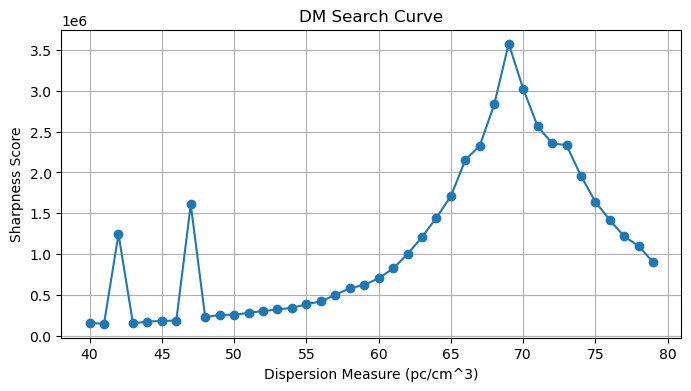

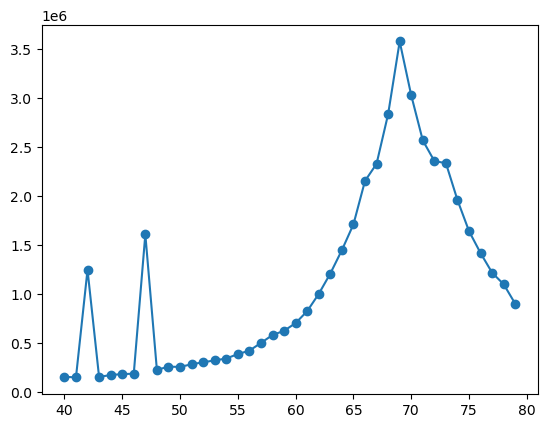

In [35]:
sample_rate=33e6
block_size=512
avg_blocks=60
freqs=np.linspace(326.5 + 8.25, 326.5 - 8.25, 256)
matrix=vela.intensity_matrix_ch2
center_freq_MHZ = 326.5
bandwidth_MHZ = 16.5
Npeaks = 10
pulseperiod_ms = 90  # ms
to_plot = False
tol = 1 # Integer better to have atleast 1

dm_min=40
dm_max=80

best_dm_grid = find_best_dm_Grid(matrix,center_freq_MHZ,bandwidth_MHZ, sample_rate, block_size, avg_blocks,Npeaks,pulseperiod_ms, to_plot,dm_min, dm_max, tol)

plt.plot(*zip(*best_dm_grid))
plt.scatter(*zip(*best_dm_grid))



In [ ]:
sample_rate=33e6
block_size=512
avg_blocks=60
freqs=np.linspace(326.5 + 8.25, 326.5 - 8.25, 256)
matrix=vela.intensity_matrix_ch2
center_freq_MHZ = 326.5
bandwidth_MHZ = 16.5
Npeaks = 10
pulseperiod_ms = 90  # ms
to_plot = True

dm_min=60
dm_max=70

best_dm = find_best_dm(matrix,center_freq_MHZ,bandwidth_MHZ, sample_rate, block_size, avg_blocks,Npeaks,pulseperiod_ms, to_plot,dm_min, dm_max, tol=1)



In [ ]:

import functions as fnc
dedisperse(matrix, DM = best_dm,block_size, avg_blocks , sample_rate , bandwidth_MHZ = 16.5,center_freq_MHZ = 326.5)
viz.plot_intensity_matrix(channel=2,dedispersed=True)

In [ ]:
sample_rate=33e6
block_size=512
avg_blocks=60
freqs=np.linspace(326.5 + 8.25, 326.5 - 8.25, 256)
matrix=vela.intensity_matrix_ch2

x , y = find_best_dm(matrix, freqs, sample_rate, block_size, avg_blocks, dm_min=65, dm_max=70, tol=1)

print(x,y)

In [ ]:
best_dm = x
Manual_dedisperse(self,channel = 1,DM = best_dm)



In [ ]:
binfile = '/home/ashwin-ubuntu/Documents/Vela_Data-20250313T050631Z-001/Vela_Data/Binary_MBR/ch00_B0833-45_snip_20150612_191438_011.mbr'

# Initialize and run the analysis
vela = PulsarDataFile(binfile, data_type='binary')
vela.load_data()



# vela.compute_intensity_matrix()

# # Visualize
# viz = Visualizer(vela)
# viz.random_sample_hist()
# viz.plot_intensity_matrix(channel=1)
# viz.plot_intensity_matrix(channel=2)




In [ ]:
# Take 512 points from the chosen column
N_choosen = vela.raw_data[:,3]

# Plot the selected data segment
plt.figure(figsize=(10, 6))
plt.plot(N_choosen)
plt.title("Selected Data Segment (512 Points)")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.show()



In [ ]:
binfile = '/home/ashwin-ubuntu/Documents/Vela_Data-20250313T050631Z-001/Vela_Data/Binary_MBR/ch00_B0833-45_snip_20150612_191438_011.mbr'

# Parameters
filename = binfile  # your binary file
dtype = np.float32        # data type (e.g., float32)
num_columns = 2           # number of columns per row

# Load binary data into a 2D array
data = np.fromfile(filename, dtype=dtype)
data = data.reshape(-1, num_columns)  # reshape to rows x columns

# Accessing columns
col1 = data[:, 0]
col2 = data[:, 1]
#col3 = data[:, 2]

print("First 5 rows:")
print(N_choosen[:100])


In [ ]:
print(vela.raw_data[:100])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

class ChunkedPulsarProcessor:
    def __init__(self, file_path, block_size=512, avg_blocks=60, sample_rate=33e6, data_type='ascii'):
        self.file_path = file_path
        self.block_size = block_size
        self.avg_blocks = avg_blocks
        self.sample_rate = sample_rate
        self.data_type = data_type
        self.chunk_size = self.block_size * self.avg_blocks * 100  # adjustable
        self.accumulated_spectrum_ch1 = []
        self.accumulated_spectrum_ch2 = []
    
    def read_ascii_chunk(self, file_obj, num_lines):
        """Read a chunk of lines from an open ASCII file object."""
        lines = []
        for _ in range(num_lines):
            line = file_obj.readline()
            if not line:
                break
            parts = line.strip().split()
            if len(parts) != 2:
                continue
            lines.append([float(parts[0]), float(parts[1])])
        return np.array(lines) if lines else None

    def process_chunk(self, data_chunk):
        """Process a single chunk of data and return the averaged power spectra."""
        def compute_channel_spectrum(channel_data):
            total = len(channel_data)
            segment_len = self.block_size * self.avg_blocks
            usable = total // segment_len
            if usable == 0:
                return None
            reshaped = channel_data[:usable * segment_len].reshape(usable * self.avg_blocks, self.block_size)
            fft_vals = np.fft.rfft(reshaped, axis=1)
            power = np.abs(fft_vals) ** 2
            power_avg = power.reshape(usable, self.avg_blocks, -1).mean(axis=1)
            return power_avg

        ch1 = data_chunk[:, 0]
        ch2 = data_chunk[:, 1]

        ps1 = compute_channel_spectrum(ch1)
        ps2 = compute_channel_spectrum(ch2)

        if ps1 is not None: self.accumulated_spectrum_ch1.append(ps1)
        if ps2 is not None: self.accumulated_spectrum_ch2.append(ps2)

    def run(self, max_chunks=None):
        # Fast ASCII loading using numpy, then process in memory by chunks
        data = np.loadtxt(self.file_path)
        total_lines = data.shape[0]
        chunk_size = self.chunk_size
        chunk_count = 0
        for start in range(0, total_lines, chunk_size):
            end = min(start + chunk_size, total_lines)
            chunk = data[start:end]
            if chunk.shape[0] == 0:
                break
            self.process_chunk(chunk)
            chunk_count += 1
            if max_chunks and chunk_count >= max_chunks:
                break
            print(f"Processed chunk {chunk_count}")

        # Combine all processed data
        self.intensity_matrix_ch1 = np.vstack(self.accumulated_spectrum_ch1)
        self.intensity_matrix_ch2 = np.vstack(self.accumulated_spectrum_ch2)

    def plot_dynamic_spectrum(self, channel=1, gamma=2.5):
        if channel == 1:
            matrix = self.intensity_matrix_ch1
        elif channel == 2:
            matrix = self.intensity_matrix_ch2
        else:
            raise ValueError("Channel must be 1 or 2.")

        time_extent = matrix.shape[0] * (self.avg_blocks * self.block_size / self.sample_rate) * 1e6  # microseconds

        plt.figure(figsize=(10, 6))
        plt.imshow(np.log1p(matrix.T), aspect='auto', origin='upper', cmap='turbo',
                   norm=colors.PowerNorm(gamma=gamma),
                   extent=(0, time_extent, matrix.shape[1], 0))
        plt.colorbar(label="Log Power")
        plt.xlabel("Time (μs)")
        plt.ylabel("Frequency Channel")
        plt.title(f"Dynamic Spectrum (Channel {channel})")
        plt.show()


In [ ]:
processor = ChunkedPulsarProcessor("/home/ashwin-ubuntu/GIT/Vela_Data_analysis/Vela_Data/ch00_B0833-45_20150612_191438_011_1", data_type='ascii')

processor.run(max_chunks=1)  # Load and process first 10 chunks
processor.plot_dynamic_spectrum(channel=1)
processor.plot_dynamic_spectrum(channel=2)


In [ ]:
import numpy as np

binfile = '/home/ashwin-ubuntu/Documents/Vela_Data-20250313T050631Z-001/Vela_Data/Binary_MBR/ch00_B0833-45_snip_20150612_191438_011.mbr'

data = np.fromfile(binfile, dtype=np.float32)
print("First few values:", data[:10])
print("Data length:", len(data))
plt.hist(data)
plt.title("Histogram of Raw Data")
plt.show()



In [ ]:
# Try int16
data = np.fromfile(binfile, dtype=np.int16)
print("First few values:", data[:10])
print("Data length:", len(data))
plt.hist(data, bins=100)
plt.title("Histogram of Raw Data")
plt.show()

# Try float64
data = np.fromfile(binfile, dtype=np.float64)
print("First few values:", data[:10])
print("Data length:", len(data))
plt.hist(data[:100000], bins=100)
plt.title("Histogram of Raw Data")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(data[:100000], bins=100)
plt.title("Histogram of Raw Data")
plt.show()


In [ ]:
import os
file_size = os.path.getsize(binfile)  # in bytes
print("File size:", file_size)

# If float32, then each value = 4 bytes
n_values = file_size / 4
print("Assuming float32, number of values:", n_values)